In [1]:
import h5py
import numpy as np

# load data
with h5py.File('data/Galaxy10_DECals.h5', 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

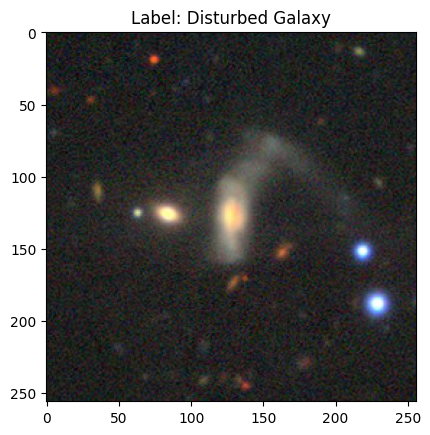

In [3]:
import matplotlib.pyplot as plt

label_map = {
    0: "Disturbed Galaxy",
    1: "Merging Galaxy",
    2: "Round Smooth Galaxy",
    3: "In-between Round Smooth Galaxy",
    4: "Cigar Shaped Smooth Galaxy",
    5: "Barred Spiral Galaxy",
    6: "Unbarred Tight Spiral Galaxy",
    7: "Unbarred Loose Spiral Galaxy",
    8: "Edge-on Galaxy without Bulge",
    9: "Edge-on Galaxy with Bulge",
}

# get first image and label
plt.imshow(images[0])
plt.title(f"Label: {label_map[labels[0]]}")
plt.show()

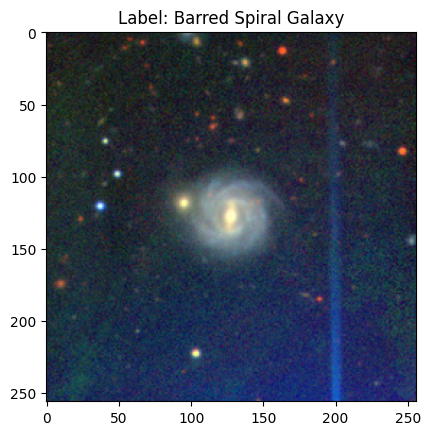

In [4]:
# experimenting with image and labels
random_index = 8943
plt.imshow(images[random_index])
plt.title(f"Label: {label_map[labels[random_index]]}")
plt.show()

In [5]:
# convert to float32
images = images.astype(np.float32) / 255.0

# keep as integers
labels = labels.astype(np.int64)

In [6]:
from sklearn.model_selection import train_test_split

# split dataset
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2)

In [18]:
import torch

# convert numpy arrays to tensors
train_images_tensor = torch.tensor(train_images).float()
train_labels_tensor = torch.tensor(train_labels).long()  
val_images_tensor = torch.tensor(val_images).float()
val_labels_tensor = torch.tensor(val_labels).long()

# permute dimensions
train_images_tensor = train_images_tensor.permute(0, 3, 1, 2)
val_images_tensor = val_images_tensor.permute(0, 3, 1, 2)


In [19]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# create tensor datasets for training and validation
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [20]:
print(images.shape)

torch.Size([32, 256, 256, 3])


In [21]:
import torch.nn as nn 
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # dropout
        self.dropout = nn.Dropout(0.25)

        # fully connected layers
        # formula: (128 * (input_width/8) * (input_height/8))
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 10) # 10 classes

    def forward(self, x):
        # apply layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # flatten output 
        x = x.view(-1, 128 * 32 * 32)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [28]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = CNN()
model.to(device=device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [30]:
# loss function
criterion = nn.CrossEntropyLoss()

# weight optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    # training
    model.train()
    total_train_loss = 0

    for images, labels in train_loader:
        # move data to cpu
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)

        # compute loss
        loss = criterion(outputs, labels)

        # backward pass, compute gradients
        optimizer.zero_grad()
        loss.backward()

        # update model paramaters
        optimizer.step()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)

    # validation
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, '
          f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 1.9668, Validation Loss: 1.8026, Validation Accuracy: 0.3179
Epoch [2/10], Train Loss: 1.8183, Validation Loss: 1.7393, Validation Accuracy: 0.3467
Epoch [3/10], Train Loss: 1.7218, Validation Loss: 1.6150, Validation Accuracy: 0.3901
Epoch [4/10], Train Loss: 1.6557, Validation Loss: 1.6327, Validation Accuracy: 0.3901
Epoch [5/10], Train Loss: 1.6010, Validation Loss: 1.5580, Validation Accuracy: 0.4205
Epoch [6/10], Train Loss: 1.5622, Validation Loss: 1.5235, Validation Accuracy: 0.4493
Epoch [7/10], Train Loss: 1.5123, Validation Loss: 1.5268, Validation Accuracy: 0.4467
Epoch [8/10], Train Loss: 1.4716, Validation Loss: 1.6448, Validation Accuracy: 0.4146
Epoch [9/10], Train Loss: 1.4304, Validation Loss: 1.5425, Validation Accuracy: 0.4386
Epoch [10/10], Train Loss: 1.3867, Validation Loss: 1.5048, Validation Accuracy: 0.4682


In [33]:
# extra validation run
def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total
    return average_val_loss, val_accuracy

val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 1.5048, Validation Accuracy: 0.4682


In [34]:
torch.save(model.state_dict(), 'model.pth')

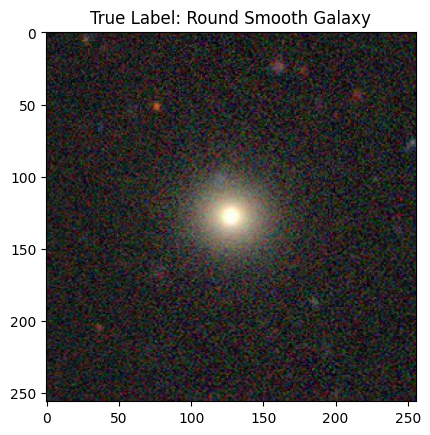

Predicted Label: Round Smooth Galaxy


In [40]:
random_index = np.random.randint(len(images))
img, lbl = images[random_index], labels[random_index]

# move tensor to cpu and convert to numpy for visualization
img = img.cpu().numpy()

# since original format of the image tensor is [channels, height, width],
# need to transpose it to [height, width, channels] for displaying
img = np.transpose(img, (1, 2, 0))

# convert tensor to python int
lbl = lbl.item()

plt.imshow(img)
plt.title(f"True Label: {label_map[lbl]}")
plt.show()

# preprocess img, normalize, and add batch dims
img_processed = torch.tensor(img).float()
img_processed = img_processed.unsqueeze(0)  
img_processed = img_processed.permute(0, 3, 1, 2) # transpose

# move to gpu
img_processed = img_processed.to(device)

# # predict
model.eval() 
with torch.no_grad():
    outputs = model(img_processed)
    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

print(f"Predicted Label: {label_map[predicted_label]}")